# Tutorial of RNN

reference : https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html
goal : predict which language a word(name) is in


In [1]:
from io import open
import glob
import os
import string
import unicodedata

In [2]:
PROJECT_DIR = "/Users/fivessun/workspace/fivessun"

In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


def find_files(path: str) -> list[str]:
    return glob.glob(path)


def convert_unicode_to_ascii(s) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
        and c in all_letters
    )


def read_lines(filename: str) -> list[str]:
    with open(filename, encoding="utf-8") as file:
        lines = file.read().strip().split("\n")
    return [convert_unicode_to_ascii(line) for line in lines]

In [4]:
category_lines = {}
all_categories = []

for filename in find_files(f"{PROJECT_DIR}/library/deeplearning/sample_data/rnn/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

for key, value in category_lines.items():
    print(f"# of {key} : {len(value)} ")

# of Czech : 519 
# of German : 724 
# of Arabic : 2000 
# of Japanese : 991 
# of Chinese : 268 
# of Vietnamese : 73 
# of Russian : 9408 
# of French : 277 
# of Irish : 232 
# of English : 3668 
# of Spanish : 298 
# of Greek : 203 
# of Italian : 709 
# of Portuguese : 74 
# of Scottish : 100 
# of Dutch : 297 
# of Korean : 94 
# of Polish : 139 


In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data as torch_data

In [6]:
class CustomDataset(torch_data.Dataset):
    def __init__(self, x_data: list[torch.Tensor], y_data: list[torch.Tensor]):
        self.x_data = x_data
        self.y_data = y_data
    
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y

In [7]:
def convert_letter_to_index(letter: str) -> int:
    """ Convert letter to index
    
    e.g. a -> 0, b -> 1, c -> 2, ..., z -> 25
    """
    return all_letters.find(letter)


def convert_letter_to_tensor(letter: str) -> torch.Tensor:
    """ Convert letter to tensor
    
    e.g. a -> [1, 0, 0, ..., 0], b -> [0, 1, 0, ..., 0], c -> [0, 0, 1, ..., 0], ..., z -> [0, 0, 0, ..., 1]
    """
    tensor = torch.zeros(1, n_letters)
    tensor[0][convert_letter_to_index(letter)] = 1
    return tensor


def convert_line_to_tensor(line: str) -> torch.Tensor:
    """ Convert line to tensor
    
    shape of output: (line_length, 1, n_letters) 
    e.g. "abc" -> [[[1, 0, 0, ..., 0]], [[0, 1, 0, ..., 0]], [[0, 0, 1, ..., 0]]]
    """
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][convert_letter_to_index(letter)] = 1
    return tensor


def convert_category_to_index(category: str) -> torch.Tensor:
    """ Convert category to index
    
    e.g. "Korean" -> 0, "English" -> 1, "Chinese" -> 2
    """
    return torch.tensor([all_categories.index(category)])

In [8]:
# Setting hyperparameters
learning_rate = 0.005
n_hidden = 128
num_epochs = 100

In [19]:
x_data = []
y_data = []

for category, lines in category_lines.items():
    for line in lines:
        x_data.append(convert_line_to_tensor(line))
        y_data.append(convert_category_to_index(category).long())
        # y_data.append(F.one_hot(convert_category_to_index(category), num_classes=len(all_categories)).type(torch.float32))

dataset = CustomDataset(x_data, y_data)
dataloader = torch_data.DataLoader(dataset, batch_size=None, shuffle=True)

In [43]:
class BasicRNN(nn.Module):
    """RNN layer.

    h_t = tanh(W_xh * x_t + W_hh * h_t-1)
    y_t = tanh(W_xy * x_t + W_hy * h_t-1)
    """

    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(BasicRNN, self).__init__()

        self.hidden_size = hidden_size

        # i2h: W_xh + W_hh
        # i2o: W_xy + W_hy
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.activation_ftn = torch.tanh
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(
            self,
            x: torch.Tensor,
            h: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """RNN forward.
        :arg:
            shape of x (x_t)   : (batch_size, input_size)
            shape of h (h_t-1) : (batch_size, hidden_size)

        :return:
            shape of y (y_t)   : (batch_size, output_size)
            shape of h (h_t)   : (batch_size, hidden_size)
        """
        # Combine input and hidden state.
        combined = torch.cat((x, h), 1)

        # It is possible to use one layer by combining i2h and i2o.
        # With only one layer, not necessarily use activation function.
        # h = self.activation_ftn(self.i2h(combined))
        # y = self.activation_ftn(self.i2o(combined))
        h = self.i2h(combined)
        y = self.i2o(combined)
        y = self.softmax(y)  # probability distribution
        return y, h


In [30]:
rnn_model = BasicRNN(n_letters, n_hidden, len(all_categories))
loss_ftn = nn.NLLLoss() # with log_softmax
optimizer = torch.optim.SGD(rnn_model.parameters(), lr=learning_rate)

In [31]:
losses = []
for epoch in range(num_epochs):
    avg_loss = 0
    for idx, (x, y) in enumerate(dataloader):
        h_0 = torch.zeros(1, n_hidden)
        # shape of x : (line_length, 1, n_letters)
        # shape of y : (1)
        # shape of h : (1, n_hidden)
        h = h_0
        for i in range(x.shape[0]):
            # Since the problem is many-to-one, we only use the last output.
            o, h = rnn_model(x[i], h)
        loss = loss_ftn(o, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} | Step {idx + 1}/{len(dataloader)} | Loss: {loss.item():.4f}")
        avg_loss += loss

    avg_loss /= len(dataloader)
    losses.append(avg_loss)


Epoch 1/100 | Step 1/20074 | Loss: 2.8962
Epoch 1/100 | Step 101/20074 | Loss: 2.8702
Epoch 1/100 | Step 201/20074 | Loss: 1.3643
Epoch 1/100 | Step 301/20074 | Loss: 0.5807
Epoch 1/100 | Step 401/20074 | Loss: 0.2403
Epoch 1/100 | Step 501/20074 | Loss: 1.6644
Epoch 1/100 | Step 601/20074 | Loss: 0.5725
Epoch 1/100 | Step 701/20074 | Loss: 0.5542
Epoch 1/100 | Step 801/20074 | Loss: 1.5283
Epoch 1/100 | Step 901/20074 | Loss: 0.5122
Epoch 1/100 | Step 1001/20074 | Loss: 0.5367
Epoch 1/100 | Step 1101/20074 | Loss: 0.2126
Epoch 1/100 | Step 1201/20074 | Loss: 0.3595
Epoch 1/100 | Step 1301/20074 | Loss: 3.2814
Epoch 1/100 | Step 1401/20074 | Loss: 0.3179
Epoch 1/100 | Step 1501/20074 | Loss: 0.6854
Epoch 1/100 | Step 1601/20074 | Loss: 0.3288
Epoch 1/100 | Step 1701/20074 | Loss: 1.6080
Epoch 1/100 | Step 1801/20074 | Loss: 0.5320
Epoch 1/100 | Step 1901/20074 | Loss: 2.0275
Epoch 1/100 | Step 2001/20074 | Loss: 0.1409
Epoch 1/100 | Step 2101/20074 | Loss: 4.1048
Epoch 1/100 | Step 220

KeyboardInterrupt: 

In [34]:
for category, lines in category_lines.items():
    for line in lines:
        category_index = convert_category_to_index(category)
        x = convert_line_to_tensor(line)
        h_0 = torch.zeros(1, n_hidden)
        h = h_0
        for i in range(x.shape[0]):
            o, h = rnn_model(x[i], h)
        
        print(torch.argmax(o, dim=1), category_index)
    break

hello
tensor([9]) tensor([0])
tensor([6]) tensor([0])
tensor([10]) tensor([0])
tensor([9]) tensor([0])
tensor([6]) tensor([0])
tensor([6]) tensor([0])
tensor([2]) tensor([0])
tensor([6]) tensor([0])
tensor([6]) tensor([0])
tensor([0]) tensor([0])
tensor([9]) tensor([0])
tensor([9]) tensor([0])
tensor([6]) tensor([0])
tensor([9]) tensor([0])
tensor([6]) tensor([0])
tensor([0]) tensor([0])
tensor([6]) tensor([0])
tensor([0]) tensor([0])
tensor([0]) tensor([0])
tensor([6]) tensor([0])
tensor([0]) tensor([0])
tensor([6]) tensor([0])
tensor([1]) tensor([0])
tensor([9]) tensor([0])
tensor([2]) tensor([0])
tensor([6]) tensor([0])
tensor([2]) tensor([0])
tensor([6]) tensor([0])
tensor([6]) tensor([0])
tensor([17]) tensor([0])
tensor([6]) tensor([0])
tensor([6]) tensor([0])
tensor([6]) tensor([0])
tensor([6]) tensor([0])
tensor([1]) tensor([0])
tensor([6]) tensor([0])
tensor([6]) tensor([0])
tensor([12]) tensor([0])
tensor([4]) tensor([0])
tensor([10]) tensor([0])
tensor([0]) tensor([0])
tensor

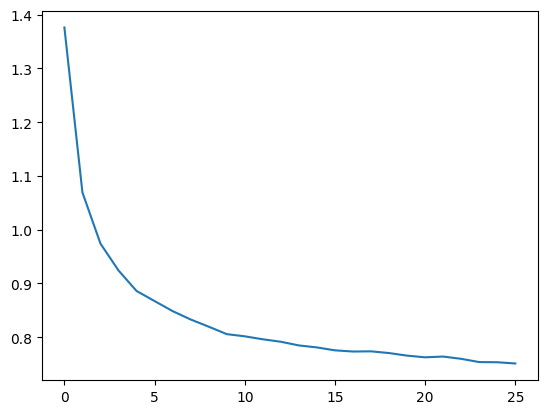

In [42]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([loss.detach().numpy() for loss in losses])